In [1]:
## Evalutate the effect of Zero phase in network inversion
## Test data: SenDT128

import os
import numpy as np
from matplotlib import ticker, pyplot as plt, gridspec
from pysar.objects import timeseries, ifgramStack, geometry, sensor
from pysar.utils import plot as pp, network as pnet, ptime
from pysar.simulation import simulation as sim
from pysar.simulation.plot import *
from pysar import ifgram_inversion as ifginv


re_generate_noise = False
lin_velocity = False
display = True


work_dir = '/Users/yunjunz/development/python/2018_ComputGeosci_PySAR/networkInv_zeroPhase'
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)
os.chdir(work_dir)
print('Go to directory: '+work_dir)

ref_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR'
ref_dir = '/Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/PYSAR'
pts_yx = [290, 415]
sensorName = sensor.project_name2sensor(ref_dir)[0]

def plot_invert_timeseries(ax, data_list, label_list, ylim=None):
    ax.plot(dates, list(data_list[0]*100.0),
            '--', lw=3, label=label_list[0], color=pp.mplColors[0])
    for data, label, i in zip(data_list[1:],
                              label_list[1:],
                              range(1, len(data_list))):
        ax.scatter(dates, list(data*100.0),
                   s=marker_size**2, label=label, color=pp.mplColors[i])
    pp.auto_adjust_xaxis_date(ax, datevector, fontSize=12, every_year=1)
    ax.set_xlabel('Time (years)', fontsize=font_size)
    ax.set_ylabel('LOS Displacement (cm)', fontsize=font_size)
    #ax.yaxis.set_label_position("right")
    #ax.yaxis.tick_right()
    if ylim is not None:
        ax.set_ylim(ylim)
    handles, labels = ax.get_legend_handles_labels()
    handles = [handles[1], handles[2], handles[0]]
    labels = [labels[1], labels[2], labels[0]]
    ax.legend(handles, labels, loc="upper left", frameon=False, fontsize=font_size)
    return ax

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/networkInv_zeroPhase


open timeseries file: timeseries.h5
write baseline list info to file: bl_list.txt
save range change time series to file.


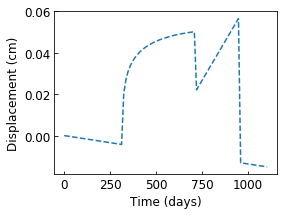

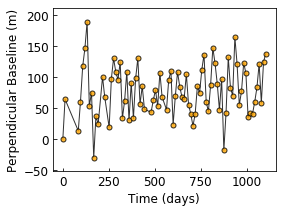

Done.


In [115]:
## 1. Simulate timeseries

ref_ts_file = os.path.join(ref_dir, 'timeseries.h5')
ts_obj = timeseries(ref_ts_file)
ts_obj.open()
date_list = ts_obj.get_date_list()
pbase_list = ts_obj.pbase.tolist()
tbase_list = ts_obj.tbase.tolist()
tbase_diff = np.diff(np.array(ptime.date_list2tbase(date_list)[0], np.float32) / 365.25).reshape(-1, 1)
dates, datevector = ptime.date_list2vector(date_list)
tbase = np.array(ts_obj.tbase)

ts_obj.save2bl_list_file(out_file='bl_list.txt')

TS_TXT_FILE = 'timeseries'
if lin_velocity:
    # Opt 1 - Linear velocity
    ts_sim = sim.velocity2timeseries(date_list, vel=0.01, display=False)
else:
    # Opt 2 - Time variable
    ts_sim = np.zeros(tbase.shape, np.float32)
    idx1 = 20
    ts_sim[idx1:] = 0.01 * np.log(tbase[idx1:] - tbase[idx1-1])
    idx2 = 50
    ts_sim[idx2:] = 0.03 + 0.06 * (tbase[idx2:] - tbase[idx2-1]) / 365.25
    idx3 = 70
    ts_sim[idx3:] = 0.
    ts_sim += tbase * -0.005 / 365.25

np.save(TS_TXT_FILE, np.hstack((np.array(date_list).reshape(-1,1), ts_sim.reshape(-1,1))))
print('save range change time series to file.')


if display:
    fig, ax = plt.subplots(figsize=[4, 3])
    ax.plot(tbase, ts_sim, '--')
    ax.set_xlabel('Time (days)', fontsize=font_size)
    ax.set_ylabel('Displacement (m)', fontsize=font_size)
    ax.tick_params(direction='in', labelsize=font_size)
    #plt.savefig('SimTimeseriesLin'+fig_ext, bbox_inches='tight', dpi=fig_dpi)
    
    fig, ax = plt.subplots(figsize=[4, 3])
    ax.plot(tbase_list, pbase_list, '-ko', alpha=0.8, lw=1, ms=marker_size, mfc='orange')
    ax = pp.auto_adjust_yaxis(ax, pbase_list, font_size)
    ax.set_xlabel('Time (days)',fontsize=font_size)
    ax.set_ylabel('Perpendicular Baseline (m)',fontsize=font_size)
    ax.tick_params(direction='in', labelsize=font_size)
    plt.show()
print('Done.')

open ifgramStack file: ifgramStack.h5
reading incidenceAngle data from file: /Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/PYSAR/INPUTS/geometryRadar.h5 ...
reading coherence data from file: /Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/PYSAR/INPUTS/ifgramStack.h5 ...


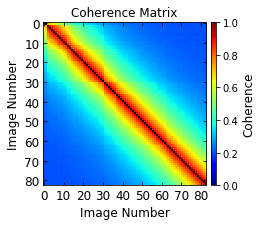

simulate unwrapped phase


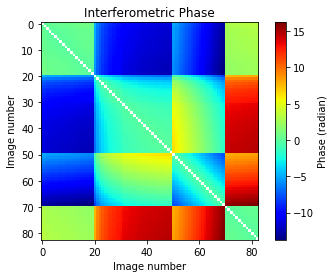

simulate decorrelation noise ...
Done.


In [116]:
# Read coherence/date12_list from reference file
stack_obj = ifgramStack(os.path.join(ref_dir, 'INPUTS/ifgramStack.h5'))
stack_obj.open()
geom_obj = geometry(os.path.join(ref_dir, 'INPUTS/geometryRadar.h5'))
inc_angle = np.nanmean(geom_obj.read(datasetName='incidenceAngle'))

date12_list = stack_obj.date12List                # use pairs from data file
date12_list = pnet.select_pairs_all(date_list)    # use all pairs for demonstration
date12_list = ptime.yyyymmdd_date12(date12_list)

box = (pts_yx[1], pts_yx[0], pts_yx[1]+1, pts_yx[0]+1)
coh = stack_obj.read(datasetName='coherence', box=box)

coh = pnet.simulate_coherence(date12_list,
                              baseline_file='bl_list.txt',
                              sensor_name=sensorName,
                              inc_angle=inc_angle,
                              decor_time=200.0,
                              coh_resid=0.2)

# Simulate coherence/date12_list
if display:
    fig, ax = plt.subplots(figsize=[4, 3])
    ax = pp.plot_coherence_matrix(ax, date12_list, coh.flatten().tolist())
    plt.show()

print('simulate unwrapped phase')
wvl = sensor.wavelength('Sen')
range2phase = -4.0 * np.pi / wvl
ifgram_sim = sim.timeseries2ifgram(ts_sim, date_list, date12_list, wvl=wvl, display=display)

print('simulate decorrelation noise ...')
L = int(stack_obj.metadata['ALOOKS']) * int(stack_obj.metadata['RLOOKS'])
decor_noise_file = 'decor_noise.npy'
if re_generate_noise or not os.path.isfile(decor_noise_file):
    decor_sim = sim.simulate_decorrelation_noises(date12_list, coh, L=L, display=display)
    np.save(decor_noise_file, decor_sim)
else:
    decor_sim = np.load(decor_noise_file)

# ifgram with decor noise
ifgram_comb = ifgram_sim + decor_sim
min_coh = 0.4
if min_coh != 0.:
    ifgram_comb[coh<min_coh] = 0.
print('Done.')

In [117]:
## Invert network of ifgrams into time-series
print('Inverting timeseries ...')
A, B = stack_obj.get_design_matrix(date12_list=date12_list)
weight = ifginv.coherence2fisher_info_index(coh, L)
ts_inv, temp_coh = ifginv.estimate_timeseries_with_phase_velocity(ifgram_comb,
                                                                  B,
                                                                  tbase_diff,
                                                                  weight,
                                                                  skip_zero_phase=True)[0:2]
ts_inv /= range2phase

ts_inv_noskip, temp_coh_noskip = ifginv.estimate_timeseries_with_phase_velocity(ifgram_comb,
                                                                                B,
                                                                                tbase_diff,
                                                                                weight,
                                                                                skip_zero_phase=False)[0:2]
ts_inv_noskip /= range2phase

print('Done.')

Inverting timeseries ...
Done.


In [118]:
# For comparison
ts0, temp_coh = ifginv.estimate_timeseries_with_phase_velocity(ifgram_sim,
                                                                  B,
                                                                  tbase_diff,
                                                                  weight,
                                                                  skip_zero_phase=True)[0:2]

A2 = np.hstack((A, np.zeros((A.shape[0],1))))
np.linalg.matrix_rank(A2)
A2_inv = np.linalg.pinv(A2)
ts = np.dot(A2_inv, ifgram_sim)

ts0 = np.dot(np.linalg.pinv(A), ifgram_sim)

u, s, vh = np.linalg.svd(A, full_matrices=False)
A_svd = np.dot(np.dot(vh.T, np.diag(1./s)), u.T)
ts_svd = np.dot(A_svd, ifgram_sim)


In [121]:
print(u.shape, s.shape, vh.shape, A.shape[1]+1)
u, s, vh = np.linalg.svd(A, full_matrices=True)
print(u.shape, s.shape, vh.shape, A.shape[1]+1)

(3403, 82) (82,) (82, 82) 83
(3403, 3403) (82,) (82, 82) 83


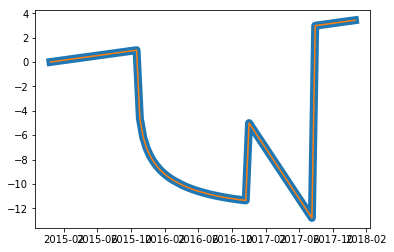

In [120]:
fig, ax = plt.subplots()
ax.plot(dates, np.vstack(([0], ts0)), lw=8)
ax.plot(dates, np.vstack(([0], ts_svd)))
plt.show()

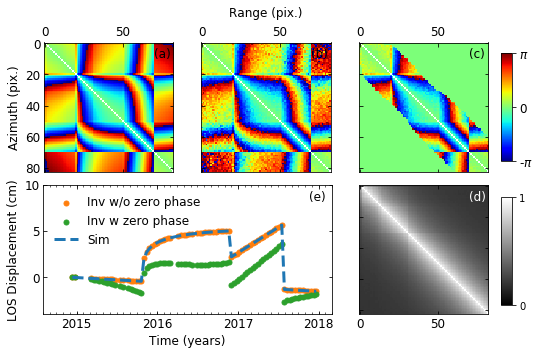

In [22]:
# plot ifgram simulation process
fig = plt.figure(figsize=[8, 5])
gs = gridspec.GridSpec(nrows=2, ncols=3, figure=fig, hspace=0.1, wspace=0.2)
ax11 = plt.subplot(gs[0, 0])
ax12 = plt.subplot(gs[0, 1])
ax13 = plt.subplot(gs[0, 2])
ax21 = plt.subplot(gs[1, 2])
ax22 = plt.subplot(gs[1, :2])

# plot ifgram simulation
wrap = True
for ax, data in zip([ax11, ax12, ax13],
                    [ifgram_sim, ifgram_sim+decor_sim, ifgram_comb]):
    data_mat = pnet.coherence_matrix(date12_list, data)
    data_mat -= np.round(data_mat/(2*np.pi)) * (2*np.pi)
    im1 = ax.imshow(data_mat, cmap='jet', vmin=-np.pi, vmax=np.pi)
ax11.set_ylabel('Azimuth (pix.)', fontsize=font_size)
pp.set_shared_xlabel([ax11, ax12, ax13], label='Range (pix.)', labelpad=0.09, position='top', font_size=font_size)

# plot coherence
data_mat = pnet.coherence_matrix(date12_list, coh)
im2 = ax21.imshow(data_mat, cmap='jet', vmin=0, vmax=1)

# plot displacement time-series
ax22 = plot_invert_timeseries(ax22, 
                              data_list=[ts_sim, ts_inv, ts_inv_noskip], #, ts_inv_sbas_noskip],
                              label_list=['Sim',
                                          'Inv w/o zero phase',
                                          'Inv w zero phase'], #,
                                          #'LS inv'],  
                              ylim=[-4, 10])   #

# setup axis format
for ax in [ax11, ax12, ax13            ]:  ax.xaxis.tick_top()
for ax in [      ax12, ax13, ax21      ]:  ax.set_yticklabels([])    #ax.xaxis.set_label_position("top")
for ax in [            ax13            ]:  ax.yaxis.tick_right()
for ax in [ax11, ax12, ax13, ax21, ax22]:
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)

# colorbars
cax1 = fig.add_axes([0.92, 0.55, 0.02, 0.3])
cbar1 = plt.colorbar(im1, cax=cax1, ticks=[-np.pi, 0, np.pi])
cbar1.ax.set_yticklabels([r'-$\pi$', '0', r'$\pi$'], fontsize=font_size)

cax2 = fig.add_axes([0.92, 0.15, 0.02, 0.3])
cbar2 = plt.colorbar(im2, cax=cax2, ticks=[0, 1])

ax11.annotate('(a)', xy=(0.85, 0.88), color='k', xycoords='axes fraction', fontsize=font_size)
ax12.annotate('(b)', xy=(0.85, 0.88), color='k', xycoords='axes fraction', fontsize=font_size)
ax13.annotate('(c)', xy=(0.85, 0.88), color='k', xycoords='axes fraction', fontsize=font_size)
ax21.annotate('(d)', xy=(0.85, 0.88), color='w', xycoords='axes fraction', fontsize=font_size)
ax22.annotate('(e)', xy=(0.92, 0.88), color='k', xycoords='axes fraction', fontsize=font_size)

plt.savefig('networkInv_zeroPhase.jpg', bbox_inches='tight', dpi=fig_dpi)
plt.show()

In [23]:
temp_coh, temp_coh_noskip

(array([ 0.99295115], dtype=float32), array([ 0.12388252], dtype=float32))